In [1]:
!wget --header="Host: doc-10-5k-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/94.0.4606.81 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9,mt;q=0.8,hi;q=0.7" --header="Cookie: AUTH_2u1gmt4j08s836ujksdlj51vps0jhs16_nonce=g63glrrhl8h4q" --header="Connection: keep-alive" "https://doc-10-5k-docs.googleusercontent.com/docs/securesc/6kbudo4ee5hqmlq3ia8ppia9sbcvjuvj/llhm2dnoep97do4r8o27lkgekv3ssug7/1635619425000/12878554966299595518/12878554966299595518/1Xql-_6UB8obmLItReI8_GGAdUU1XJkCr?e=download&authuser=0&nonce=g63glrrhl8h4q&user=12878554966299595518&hash=6jopnp4ntuhqf4ir2i04fbm4ikfp4vtf" -c -O 'cornell_movie_dialogs_corpus.zip'

--2021-10-30 18:45:04--  https://doc-10-5k-docs.googleusercontent.com/docs/securesc/6kbudo4ee5hqmlq3ia8ppia9sbcvjuvj/llhm2dnoep97do4r8o27lkgekv3ssug7/1635619425000/12878554966299595518/12878554966299595518/1Xql-_6UB8obmLItReI8_GGAdUU1XJkCr?e=download&authuser=0&nonce=g63glrrhl8h4q&user=12878554966299595518&hash=6jopnp4ntuhqf4ir2i04fbm4ikfp4vtf
Resolving doc-10-5k-docs.googleusercontent.com (doc-10-5k-docs.googleusercontent.com)... 108.177.97.132, 2404:6800:4008:c00::84
Connecting to doc-10-5k-docs.googleusercontent.com (doc-10-5k-docs.googleusercontent.com)|108.177.97.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9916637 (9.5M) [application/x-zip-compressed]
Saving to: ‘cornell_movie_dialogs_corpus.zip’

cornell_movie_dialo 100%[===================>]   9.46M  30.4MB/s    in 0.3s    

2021-10-30 18:45:05 (30.4 MB/s) - ‘cornell_movie_dialogs_corpus.zip’ saved [9916637/9916637]



In [2]:
!unzip cornell_movie_dialogs_corpus.zip

Archive:  cornell_movie_dialogs_corpus.zip
   creating: cornell movie-dialogs corpus/
  inflating: cornell movie-dialogs corpus/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/cornell movie-dialogs corpus/
  inflating: __MACOSX/cornell movie-dialogs corpus/._.DS_Store  
  inflating: cornell movie-dialogs corpus/chameleons.pdf  
  inflating: __MACOSX/cornell movie-dialogs corpus/._chameleons.pdf  
  inflating: cornell movie-dialogs corpus/movie_characters_metadata.txt  
  inflating: cornell movie-dialogs corpus/movie_conversations.txt  
  inflating: cornell movie-dialogs corpus/movie_lines.txt  
  inflating: cornell movie-dialogs corpus/movie_titles_metadata.txt  
  inflating: cornell movie-dialogs corpus/raw_script_urls.txt  
  inflating: cornell movie-dialogs corpus/README.txt  
  inflating: __MACOSX/cornell movie-dialogs corpus/._README.txt  


In [3]:
import tensorflow as tf
tf.random.set_seed(1234)

import tensorflow_datasets as tfds

import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
#we will be working only using 100000 samples
MAX_SAMPLES = 100000

def preprocess_sentence(sentence):
    #converting everything to lower case
    sentence = sentence.lower().strip()
 
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    # removing unnecessary space
    sentecne = re.sub(r'[" "]+', " ", sentence)
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    sentence = re.sub(r"[^a-zA-Z?.,!]+", " ", sentence)
    #removal of trailing spaces
    sentence = sentence.strip()

    return sentence

def load_conversations():
    # dictionary of line id to text
    id2line = {}
    with open('/content/cornell movie-dialogs corpus/movie_lines.txt', encoding = 'utf-8', errors = 'ignore') as file:
        lines = file.readlines()
    for line in lines:
        parts = line.replace('\n', '').split(' +++$+++ ')
        id2line[parts[0]] = parts[4]
        
    inputs, outputs = [], []
    with open('/content/cornell movie-dialogs corpus/movie_conversations.txt', 
                     encoding = 'utf-8', errors = 'ignore') as file:
        lines = file.readlines()
    for line in lines:
        parts = line.replace('\n', '').split(' +++$+++ ')
        # get conversation in a list of line ID
        conversation = [line[1:-1] for line in parts[3][1:-1].split(', ')]
        for i in range(len(conversation) - 1):
            inputs.append(preprocess_sentence(id2line[conversation[i]]))
            outputs.append(preprocess_sentence(id2line[conversation[i + 1]]))
            if len(inputs) >= MAX_SAMPLES:
                return inputs, outputs
    return inputs, outputs

questions, answers = load_conversations()

In [5]:
#creation of data frames containing questions and answers generated from the data
df_data=pd.DataFrame({'questions':questions,'answers':answers})
df_data.columns=['questions','answers']

In [6]:
from sklearn.model_selection import train_test_split
train, validation=train_test_split(df_data, test_size=0.2, random_state=42)

In [7]:
# Build tokenizer for both questions and answers
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(df_data['questions'] + df_data['answers'], target_vocab_size = 2**13)

# Define start and end token to indicate the start and end of a sentence
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# Vocabulary size plus start and end token
VOCAB_SIZE = tokenizer.vocab_size + 2

In [9]:
import pickle
pickle.dump(tokenizer,open('tokenizer.pkl', 'wb'))

In [10]:
# Maximum sentence length
MAX_LENGTH = 23

# Tokenize, filter and pad sentences
def tokenize_and_filter(inputs, outputs):
    
    '''
    
    The function accepts the questions and answers and encodes followed by padding each question and answer using the tokenizer trained on the above corpus
    
    Args:
         inputs-questions
         outputs-answers
         
    Returns:
         tokenized_inputs-tokenized and padded questions .
         tokenized_decoder_inp- tokenized and padded decoder inputs to be fed to the decoder.
         tokenized_decoder_out- tokenized and padded decoder outputs expected at the decoder end.
    
    '''
    tokenized_inputs, tokenized_decoder_inp, tokenized_decoder_out = [], [], []
    
    for (sentence1, sentence2_) in zip(inputs, outputs):
        # tokenize sentence
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2_) 
        sentence3 = tokenizer.encode(sentence2_) + END_TOKEN

        # check tokenized sentence max length
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_decoder_inp.append(sentence2)
            tokenized_decoder_out.append(sentence3)
            
    # pad tokenized sentences
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(tokenized_inputs, maxlen = MAX_LENGTH, padding = 'post')
    tokenized_decoder_inp = tf.keras.preprocessing.sequence.pad_sequences(tokenized_decoder_inp, maxlen=MAX_LENGTH-1, padding = 'post')
    tokenized_decoder_out = tf.keras.preprocessing.sequence.pad_sequences(tokenized_decoder_out, maxlen=MAX_LENGTH-1, padding= 'post')
    
    return tokenized_inputs, tokenized_decoder_inp, tokenized_decoder_out

train_questions, train_decoder_inp, train_decoder_out= tokenize_and_filter(train['questions'], train['answers'])
validation_questions, validation_decoder_inp, validation_decoder_out = tokenize_and_filter(validation['questions'], validation['answers'])


In [11]:
print('Vocab size: {}'.format(VOCAB_SIZE))
#print('Number of samples: {}'.format(len(questions)))

Vocab size: 8194


In [12]:
import pandas as pd
import numpy as np

In [13]:
#will be using a batch size of 128.
BATCH_SIZE = 128
BUFFER_SIZE = 20000



train_dataset = tf.data.Dataset.from_tensor_slices(((train_questions,train_decoder_inp),train_decoder_out))
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

BUFFER_SIZE=1000

validation_dataset = tf.data.Dataset.from_tensor_slices(((validation_questions, validation_decoder_inp),validation_decoder_out))
validation_dataset = validation_dataset.cache()
validation_dataset = validation_dataset.shuffle(BUFFER_SIZE)
validation_dataset = validation_dataset.batch(BATCH_SIZE)
validation_dataset = validation_dataset.prefetch(tf.data.experimental.AUTOTUNE)




In [14]:
#REFERENCE-https://blog.tensorflow.org/2019/05/transformer-chatbot-tutorial-with-tensorflow-2.html

def scaled_dot_product_attention(query, key, value, mask):
    """Calculate the attention weights."""
    matmul_qk = tf.matmul(query, key, transpose_b = True)
    
    # scale matmul_qk
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)
    
    # add the mask to zero out padding tokens
    if mask is not None:
        logits += (mask * -1e9)
        
    #sofmax is normalized on the last axis (seq_len_k)
    attention_weights = tf.nn.softmax(logits, axis = -1)
    
    output = tf.matmul(attention_weights, value)
    
    return output

In [26]:
#REFERENCE-https://blog.tensorflow.org/2019/05/transformer-chatbot-tutorial-with-tensorflow-2.html

class MultiHeadAttention(tf.keras.layers.Layer):
  '''
  A class for multi head attention calculation 
  '''

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super().__init__()
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # linear layers
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)


    # split heads
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # scaled dot-product attention
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # concatenation of heads
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # final linear layer
    outputs = self.dense(concat_attention)

    return outputs

In [16]:
def create_padding_mask(x):
    '''
    For masking the encoder inputs
    
    '''
    # tf.math.equal returns the truth value of (x == y) element-wise
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]


In [17]:
def create_look_ahead_mask(x):
     '''
     For masking the decoder inputs
     
     '''
    
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1- tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    # tf.maximum returns the max of x and y (i.e. x>y?x:y) element-wise
    return tf.maximum(look_ahead_mask, padding_mask)

In [18]:
class PositionalEncoding(tf.keras.layers.Layer):
    
    
    def __init__(self, position, d_model):
        super().__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)
        
    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000,(2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles
    
    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(position = tf.range(position, dtype=tf.float32)[:, tf.newaxis], i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :], d_model = d_model)
        # apply sin to even index in the array
        sines = tf.math.sin(angle_rads[:, 1::2])
        # apply cos to odd index in the array
        cosines = tf.math.cos(angle_rads[:, 1::2])
        
        # negative axis refers to axis + rank(values)-th dimension.
        pos_encoding = tf.concat([sines, cosines], axis = -1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)
    
    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In [19]:
class EncoderLayer(tf.keras.layers.Layer):
    
  

  def __init__(self, units, d_model, num_heads, dropout, name="encoder_layer"):
      super().__init__()
      self.units=units
      self.d_model=d_model
      self.num_heads=num_heads
      self.dropout=dropout
      self.attention = MultiHeadAttention(d_model=self.d_model, num_heads=self.num_heads, name="multi_head_attention")
      self.dropout_layer=Dropout(self.dropout)
      self.layer_normalization1=LayerNormalization(epsilon=1e-6)
      self.dense1=Dense(self.units, activation='relu')
      self.dense2=Dense(self.d_model)
      self.layer_normalization2=LayerNormalization(epsilon=1e-6)


  def call(self, input, padding_mask):
      '''
      input has to be in the form of a dictionary
      input={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      }   

      '''
      att_input={'query':input,'key':input,'value':input, 'mask':padding_mask}

      attention_output=self.attention(att_input)
      attention_output=self.dropout_layer(attention_output)
      attention_output=self.layer_normalization1(input+attention_output)
      output=self.dense1(attention_output)
      output=self.dense2(output)
      output=self.dropout_layer(output)
      output=self.layer_normalization2(output+attention_output)

      return output

In [20]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size,num_layers,units, d_model, num_heads, dropout, name='encoder'):
       super().__init__()
       self.vocab_size=vocab_size
       self.units=units
       self.num_layers=num_layers
       self.d_model=d_model
       self.num_heads=num_heads
       self.dropout=dropout
       #self.position=position
       self.embedding=Embedding(input_dim=self.vocab_size,output_dim=self.d_model)
       self.positional_encoding=PositionalEncoding(position=self.vocab_size, d_model=self.d_model)
       self.dropout_layer=Dropout(self.dropout)
       self.enc_layers = [EncoderLayer(units=self.units, d_model=self.d_model, num_heads=self.num_heads, dropout=self.dropout, name="encoder_layer_{}".format(i))  for i in range(self.num_layers)]
      

    def call(self,input, padding_mask):
      embedd_output=self.embedding(input)
      embedd_output *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
      embeddings=self.positional_encoding(embedd_output)
      outputs=self.dropout_layer(embeddings)

      for i in range(self.num_layers):
            outputs = self.enc_layers[i](outputs, padding_mask)
      return outputs   

In [21]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, units, d_model, num_heads,dropout, name = "decoder_layer"):
      super().__init__()
      self.units=units
      self.d_model=d_model
      self.num_heads=num_heads
      self.dropout=dropout
      self.attention1 = MultiHeadAttention(d_model=self.d_model, num_heads=self.num_heads, name="attention_1")
      self.attention2 = MultiHeadAttention(d_model=self.d_model, num_heads=self.num_heads, name="attention_2")
      self.layernorm1=LayerNormalization(epsilon=1e-6)
      self.layernorm2 = LayerNormalization(epsilon=1e-6)
      self.layernorm3 = LayerNormalization(epsilon=1e-6)
      self.dropout1 = Dropout(self.dropout)
      self.dropout2 = Dropout(self.dropout)
      self.dropout3 = Dropout(self.dropout)
      self.dense1 = Dense(self.units, activation='relu')
      self.dense2 = Dense(self.d_model)
  
  def __call__(self,inputs,encoder_outputs,look_ahead_mask, padding_mask):
      att_input={'query':inputs, 'key': inputs, 'value': inputs, 'mask':look_ahead_mask}
      attention_1=self.attention1(att_input)
      attention_1=self.dropout1(attention_1)
      attention_1=self.layernorm1(attention_1+inputs)
  
      att_input2={'query':attention_1,'key':encoder_outputs, 'value':encoder_outputs,'mask':padding_mask}
      attention_2=self.attention2(att_input2)
      
      attention_2=self.dropout2(attention_2)
      attention_2=self.layernorm2(attention_1+attention_2)
      output=self.dense1(attention_2)
      output=self.dense2(output)
      output=self.dropout3(output)
      output=self.layernorm3(output+attention_2)
      return output

   

In [22]:
class Decoder(tf.keras.layers.Layer):
      def __init__(self,vocab_size, num_layers,units,d_model,num_heads, dropout,name='decoder'):
           super().__init__()
           self.vocab_size=vocab_size
           self.num_layers=num_layers
           self.units=units
           self.d_model=d_model
           self.num_heads=num_heads
           self.dropout=dropout
           self.embedding=Embedding(input_dim=self.vocab_size, output_dim=self.d_model)
           self.positional_embedding=PositionalEncoding(self.vocab_size, self.d_model)
           self.dropout_layer=Dropout(self.dropout)
           self.dec_layers = [DecoderLayer(units=self.units, d_model=self.d_model, num_heads=self.num_heads, dropout=self.dropout, name="decoder_layer_{}".format(i))  for i in range(self.num_layers)]

      def call(self, inputs, encoder_outputs, look_ahead_mask, padding_mask):
           embeddings=self.embedding(inputs)
           embeddings *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
           embeddings = self.positional_embedding(embeddings)
           output=self.dropout_layer(embeddings)
           for i in range(self.num_layers):
               output=self.dec_layers[i](output, encoder_outputs, look_ahead_mask, padding_mask)

           return output

          

In [23]:
class Transformer(tf.keras.Model):
      def __init__(self,vocab_size,num_layers,units, d_model, num_heads, dropout):
          super().__init__()
          self.vocab_size = vocab_size
          self.num_layers = num_layers
          self.units = units
          self.d_model = d_model
          self.num_heads = num_heads
          self.dropout = dropout
          self.enc_padding_mask=Lambda(create_padding_mask, output_shape=(1, 1, None),name="enc_padding_mask")
          self.dec_padding_mask=Lambda(create_padding_mask, output_shape=(1, 1, None),name="dec_padding_mask")
          self.look_ahead_mask=Lambda(create_look_ahead_mask,output_shape=(1, None, None),name = "look_ahead_mask")
          self.encoder = Encoder(vocab_size=self.vocab_size, num_layers=self.num_layers, units=self.units, d_model=self.d_model, num_heads=self.num_heads, dropout=self.dropout, name='encoder')
          self.decoder = Decoder(vocab_size=self.vocab_size, num_layers=self.num_layers, units=self.units, d_model=self.d_model, num_heads=self.num_heads, dropout=self.dropout, name='decoder')
          self.dense1 = Dense(units=self.vocab_size, name="outputs")

      def call(self, data):
         
          encoder_input = data[0]
          decoder_input=data[1]
          enc_padding_mask=self.enc_padding_mask(encoder_input)
      
          dec_input_look_ahead_mask=self.look_ahead_mask(decoder_input)
          enc_output=self.encoder(encoder_input,enc_padding_mask)
          decoder_padding_mask=self.dec_padding_mask(encoder_input)

          dec_output=self.decoder(decoder_input, enc_output, dec_input_look_ahead_mask, decoder_padding_mask)
          outputs = self.dense1(dec_output)
          return outputs

In [24]:
import tensorflow as tf
from tensorflow.keras.layers import *

In [97]:
tf.keras.backend.clear_session()

# Hyper-parameters
NUM_LAYERS = 2
D_MODEL = 512
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.2

model = Transformer(vocab_size = VOCAB_SIZE, num_layers=NUM_LAYERS, units = UNITS, d_model = D_MODEL, num_heads = NUM_HEADS,
                    dropout = DROPOUT)

In [78]:
#REFERENCE-https://blog.tensorflow.org/2019/05/transformer-chatbot-tutorial-with-tensorflow-2.html


def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits= True, reduction='none')(y_true, y_pred)
    
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)
    
    return tf.reduce_mean(loss)

In [79]:
#REFERENCE-https://blog.tensorflow.org/2019/05/transformer-chatbot-tutorial-with-tensorflow-2.html


class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        
        self.warmup_steps = warmup_steps
        
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)
        
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

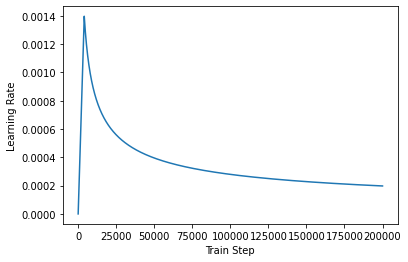

In [30]:
#REFERENCE-https://blog.tensorflow.org/2019/05/transformer-chatbot-tutorial-with-tensorflow-2.html

sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [98]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
#optimizer = tf.keras.optimizers.Adam(0.001, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
def accuracy(y_true, y_pred):
    # ensure labels have shape (batch_size, MAX_LENGTH - 1)
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH-1 ))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)
reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor= 0.1, patience=1, verbose=1,mode='min', min_delta=0.001, cooldown=0, min_lr=0)
model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
early_stop=tf.keras.callbacks.EarlyStopping( monitor='val_loss', min_delta=0.0001, patience=1, verbose=0,mode='min', restore_best_weights=True)


In [99]:
EPOCHS = 50

history=model.fit(train_dataset, validation_data=validation_dataset, epochs = EPOCHS, callbacks=[ early_stop])

Epoch 1/50
414/414 [==============================] - 51s 104ms/step - loss: 3.1136 - accuracy: 0.0575 - val_loss: 2.3712 - val_accuracy: 0.1043
Epoch 2/50
414/414 [==============================] - 42s 101ms/step - loss: 2.2030 - accuracy: 0.1159 - val_loss: 2.0445 - val_accuracy: 0.1251
Epoch 3/50
414/414 [==============================] - 42s 101ms/step - loss: 2.0002 - accuracy: 0.1278 - val_loss: 1.9396 - val_accuracy: 0.1336
Epoch 4/50
414/414 [==============================] - 42s 100ms/step - loss: 1.9015 - accuracy: 0.1347 - val_loss: 1.8730 - val_accuracy: 0.1380
Epoch 5/50
414/414 [==============================] - 42s 100ms/step - loss: 1.8304 - accuracy: 0.1398 - val_loss: 1.8459 - val_accuracy: 0.1411
Epoch 6/50
414/414 [==============================] - 42s 100ms/step - loss: 1.7673 - accuracy: 0.1452 - val_loss: 1.8211 - val_accuracy: 0.1421
Epoch 7/50
414/414 [==============================] - 42s 100ms/step - loss: 1.7069 - accuracy: 0.1499 - val_loss: 1.8119 - val_ac

In [90]:
model.summary(
)

Model: "transformer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
enc_padding_mask (Lambda)    multiple                  0         
_________________________________________________________________
dec_padding_mask (Lambda)    multiple                  0         
_________________________________________________________________
look_ahead_mask (Lambda)     multiple                  0         
_________________________________________________________________
encoder (Encoder)            multiple                  6826496   
_________________________________________________________________
decoder (Decoder)            multiple                  8929792   
_________________________________________________________________
outputs (Dense)              multiple                  4203522   
Total params: 19,959,810
Trainable params: 19,959,810
Non-trainable params: 0
___________________________________________

[]

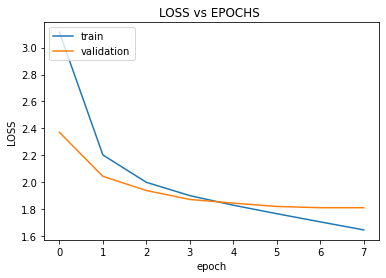

In [100]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('LOSS')
plt.xlabel('epoch')
plt.title(f'LOSS vs EPOCHS ')
plt.legend(['train', 'validation'], loc='upper left')
plt.plot()

[]

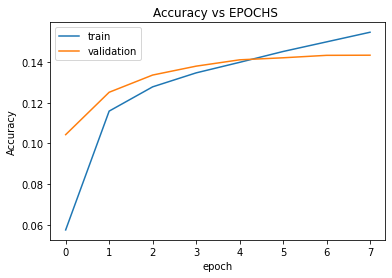

In [101]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.title(f'Accuracy vs EPOCHS ')
plt.legend(['train', 'validation'], loc='upper left')
plt.plot()

In [107]:
model.save_weights('transformer')

In [102]:
def evaluate(sentence,model):
    
    '''
    A function for prediction of the input sentence to the model
    
    Args:
         sentence-input sentence by the user
         model- model the input is fed to
         
    Returns:
           output- a tokenized form of predicted sentence
    '''
    sentence = preprocess_sentence(sentence)
    
    sentence = tf.expand_dims(START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis = 0)
    
    output = tf.expand_dims(START_TOKEN, 0)

    #output = tf.expand_dims(START_TOKEN, 0)
    for i in range(MAX_LENGTH):
        enc_padding_mask = model.layers[0](sentence)
        dec_input_look_ahead_mask=model.layers[2](output)
        enc_output=model.layers[3](sentence,enc_padding_mask)
        decoder_padding_mask=model.layers[1](sentence)
        dec_output=model.layers[4](output, enc_output, dec_input_look_ahead_mask, decoder_padding_mask)
        predictions=model.layers[5](dec_output)

        
        # select the last word from the seq_len dimension
        predictions = predictions[:, -1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
        
        # return the result if the predicted_id is equal to the end token
        if tf.equal(predicted_id, END_TOKEN[0]):
            break
            
        # concatenated the predicted_id to the output which is given to the decoder at its input.
        output = tf.concat([output, predicted_id], axis=-1)
        
    return tf.squeeze(output, axis = 0)

def predict(sentence,model):
    '''
    This function predicts the output from the chatbot given the input by the user
    
    Args:
         sentence- input sentence to the chat bot
         model- model input is fed to
         
    Returns:
           predicted_sentence- the output generated by the model
    '''
    prediction = evaluate(sentence,model)
    
    predicted_sentence = tokenizer.decode([i for i in prediction if i < tokenizer.vocab_size])
    
    #print('Input: {}'.format(sentence))
    #print('Output: {}'.format(predicted_sentence))
    
    return predicted_sentence

In [103]:
predict('I think I know you',model)

'i don t want to talk about it .'

In [104]:
input_sentence=['hello',
                'how are you',
                'once upon a  time there was a man',
                'are you sure you will be alright',
                'are you coming with me to London',
                'do you know me']
for i in input_sentence:
    print("Question-> ",i)
    print("BOT-> ",predict(i,model))

Question->  hello
BOT->  i m sorry .
Question->  how are you
BOT->  i m sorry , i m sorry . i m sorry .
Question->  once upon a  time there was a man
BOT->  i don t know what you re talking about .
Question->  are you sure you will be alright
BOT->  i m not going to be a little while .
Question->  are you coming with me to London
BOT->  i m sorry , i m sorry .
Question->  do you know me
BOT->  i don t want to talk about it .


In [106]:
from  nltk.translate.bleu_score import sentence_bleu
val=validation.sample(1000)
predicted=[]
references=[]
bleu=[]
for i in range(1000):
    
     candidate=predict(val['questions'].iloc[i],model).split()
     reference=val['answers'].iloc[i].split()
     bleu.append(sentence_bleu(reference,candidate,weights=[0.25,0.25,0.25,0.25]))
bleu_score=np.mean(bleu)
print("The average BLEU score of these sentences is", bleu_score)

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


The average BLEU score of these sentences is 0.6780326604128989


<h2> OBSERVATION </h2>

We can certainly say by looking at the BLEU score which is our performance metric for this case study, this transformer model is performing fairly well in comparison to all other models.